# Setup

In [2]:
# Imports
from pprint import pprint
from copy import copy
import sqlite3 as sql
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from bitarray import bitarray
from collections import Counter

In [224]:
def arrayEquals(a1, a2):
    if len(a1) != len(a2):
        return False
    else:
        for i in range(len(a1)):
            if a1[i] != a2[i]:
                return False
    return True

def binaryRap(value):
    res = [0 for i in range(8)]
    if value >= 0:
        tmp = 0
        for i in range(1,8):
            j = 7-i
            if tmp + 2 ** j <= value:
                tmp += 2 ** j
                res[j] = 1
    else:
        tmp = -128
        res[7] = 1
        for i in range(1,8):
            j = 7-i
            if tmp + 2 ** j <= value:
                tmp += 2 ** j
                res[j] = 1
    res.reverse()
    return res

def getMiddlePoints(arr):
    l = len(arr)-1
    res = [0 for i in range(l)]
    for i in range(l):
        res[i] = (arr[i]+arr[i+1]) / 2
    return res
        
    

mydb_c = sql.connect("my.db")
mydb_c.row_factory = sql.Row
mydb = mydb_c.cursor()
gold_c = sql.connect("data/gold.db")
gold = gold_c.cursor()
print("DONE")

DONE


All the weights are in the ragne -

# Preliminary Data

## Weights distribution

Collecting weights distributions

### Aggregated on layers

150
Range [-67, 105]
604
[72, 81, 78, 70, 74, 79, 71, 79]


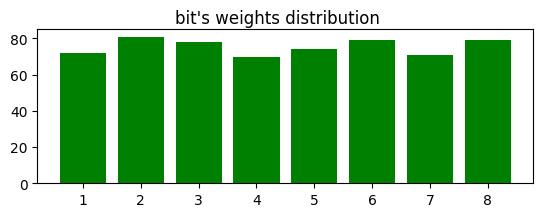

Total is: 150 (should be 150)


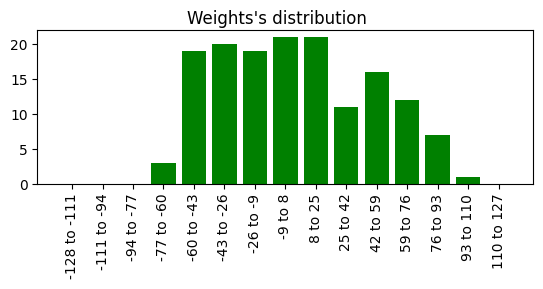

In [227]:
f = open("weights.dat")
weights = []
weightsPerLayer = {}
line = f.readline()
layer = 0
while len(line) != 0:
    if "weights" in line:
        layer += 1
    else:
        tmp = line.replace(",\n", "").replace("\n", "").replace(" ", "").replace(";", "").replace("{", "").replace("}", "").split(",")
        weights.extend(tmp)
        if layer in weightsPerLayer:
            weightsPerLayer[layer].extend(tmp)
        else:
            weightsPerLayer.update({layer: tmp})
    line = f.readline()
f.close()
    
weights = [int(i) for i in weights]
print(len(weights))
print(f"Range [{min(weights)}, {max(weights)}]")

weightsBin = [binaryRap(i) for i in weights]

frequencies = [0 for i in range(8)]
for i in range(0, 8):
    frequencies[i] = 0
    for el in weightsBin:
        frequencies[i] += el[i]
print(sum(frequencies))
pprint(frequencies)
f = plt.figure()
f.set_figheight(2)
plt.suptitle("bit's weights distribution")
plt.bar(range(1,9), frequencies, color="green")
plt.savefig("figures/bitsWeightsDistribution", bbox_inches="tight")
plt.show()

n_range = 15
e_min = -128
e_max = 127
buckSize = (e_max - e_min) // n_range
weightsDistrBuckets = {}
for i in range(n_range):
    tmp = filter(lambda j: j>=i*buckSize+e_min and j<(i+1)*buckSize+e_min, weights)
    weightsDistrBuckets.update({i*buckSize+e_min: len(list(tmp))})
    
weightsDistrBuckets[list(weightsDistrBuckets.keys())[-1]] += len(list(filter(lambda i: i>=n_range*buckSize+e_min, weights))) # Last element 
    
print("Total is: "+ str(sum(weightsDistrBuckets.values())) + " (should be 150)")
    
f = plt.figure()
f.set_figheight(2)
ax = plt.bar(["{:d} to {:d}".format(i*buckSize+e_min, (i+1)*buckSize+e_min) for i in range(n_range)], weightsDistrBuckets.values(), color="green")
#ax.bar_label(["{:.1f}-{:.1f}".format()])
plt.suptitle("Weights's distribution")
plt.xticks(rotation=90, ha='center')
plt.savefig("figures/WeightsDistrubution", bbox_inches="tight")
plt.show()

### Distribution per layer

In [87]:
for i in range(6,3, -1):
    print(i)

6
5
4


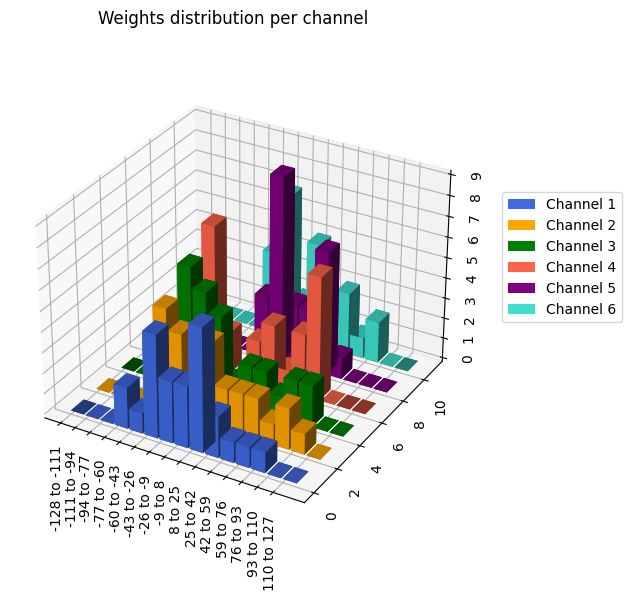

In [182]:
x = [i*10 for i in range(6)]

COLORS = ["royalblue", "orange", "green", "tomato", "purple", "turquoise"]

xbar = []
ybar = []
zbar = []
dx = []
dy = []
dz = []
colors = []

n_bins = 15
legend_proxies = [0 for i in range(n_bins)]
bins = [i*buckSize+e_min for i in range(n_range+1)]
binsLabels = ["{:d} to {:d}".format(i*buckSize+e_min, (i+1)*buckSize+e_min) for i in range(n_range)]

f = plt.figure(figsize=(6,6))
axes = f.add_subplot(1,1,1, projection='3d')
pos = 0
for i in weightsPerLayer.values():
#for index in range(6,0, -1):
    #i = weightsPerLayer[index]
    values = [int(j) for j in i]
    
    buckets = {}
    for i in range(n_range):
        tmp = filter(lambda j: j>=i*buckSize+e_min and j<(i+1)*buckSize+e_min, values)
        buckets.update({i*buckSize+e_min: len(list(tmp))})
    buckets[list(buckets.keys())[-1]] += len(list(filter(lambda i: i>=n_range*buckSize+e_min, buckets))) # Last element 
    
    xx = bins[:-1]
    yy = [pos for i in range(n_bins)]
    zz = [0 for i in range(n_bins)]
    dxx = [15 for i in range(n_bins)]
    dyy = [1 for i in range(n_bins)]
    dzz = buckets.values()
    
    #axes.bar3d(xx, yy, zz, dxx, dyy, dzz, color=COLORS[int(pos/2)], shade=True)
    
    xbar.extend(xx)
    ybar.extend(yy)
    zbar.extend(zz)
    dx.extend(dxx)
    dy.extend(dyy)
    dz.extend(dzz)
    
    index = int(pos/2)
    
    colors.extend([COLORS[index] for i in range(90)])
    legend_proxies[index] = plt.Rectangle((0,0), 1, 1, fc=COLORS[index])
    pos += 2
    
axes.bar3d(xbar, ybar, zbar, dx, dy, dz, color=colors, shade=True)
axes.set_xticks(bins[:-1], labels=binsLabels, ha="left")
axes.tick_params(rotation=90)

f.suptitle("Weights distribution per channel")
axes.legend(legend_proxies, ["Channel {}".format(i) for i in range(1,7)], bbox_to_anchor=[1.05,0.75], loc="upper left")
    
plt.savefig("figures/WeightsDistributionPerLayer3D", bbox_inches="tight")
    
plt.show()


<Figure size 300x300 with 0 Axes>

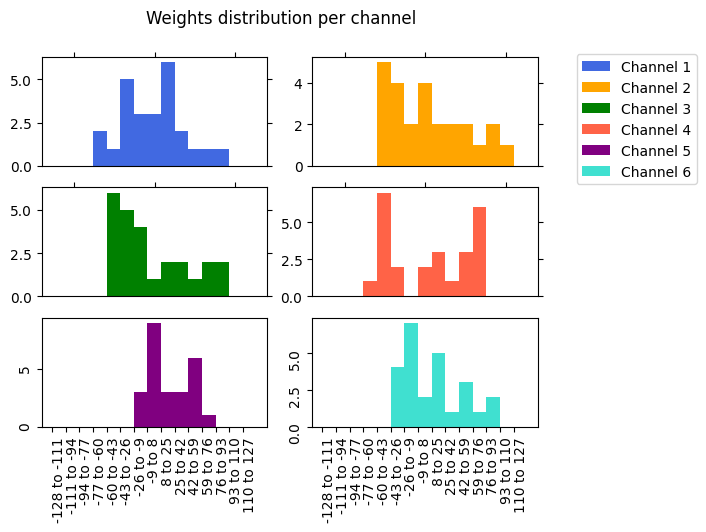

In [177]:
pos = 0
fig = plt.figure(figsize=(3,3))
fig, axes = plt.subplots(3,2)
for i in weightsPerLayer.values():
    values = [int(j) for j in i]
    #print(values)

    buckets = {}
    for i in range(n_range):
        tmp = filter(lambda j: j>=i*buckSize+e_min and j<(i+1)*buckSize+e_min, values)
        buckets.update({i*buckSize+e_min: len(list(tmp))})
    buckets[list(buckets.keys())[-1]] += len(list(filter(lambda i: i>=n_range*buckSize+e_min, buckets))) # Last element 
    
    current_ax = axes[pos // 2][pos % 2]
    
    current_ax.hist(values, alpha=1, bins=bins, color=COLORS[pos])
    if pos >= 4:
        current_ax.set_xticks(bins[:-1], labels=binsLabels, ha="left")
        current_ax.tick_params(labelrotation=90)
    else:
        current_ax.tick_params(reset=True, bottom=False, labelbottom=False)
        
    #ax[pos // 2][pos % 2].set_xticklabels(binsLabels)
    #print(fig)
    #print(buckets.values())
    pos += 1
    #plt.xticks(rotation=30, ha="right")

fig.suptitle("Weights distribution per channel")
fig.legend([f"Channel {i}" for i in range(1,7)], bbox_to_anchor=[.95,.90], loc="upper left")
plt.savefig("figures/WeightsDistributionPerChannel2D", bbox_inches="tight")
plt.show()

## Injections distributions

### Vertical position (vertical depth)

200


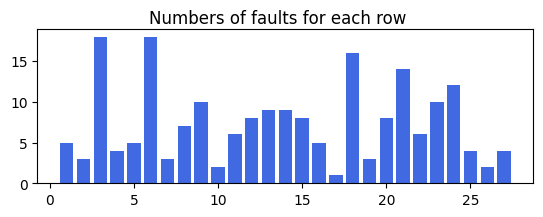

In [188]:
# vertial value faults barchart
mydb.execute("select p1 from faults")
row = mydb.fetchone()[0]
faultDepths = {}
while row is not None:
    if row in faultDepths:
        faultDepths[row] += 1
    else:
        faultDepths.update({row : 1})

    row = mydb.fetchone()
    if row is not None:
        row = row[0]
#pprint(faultDepths)
f = plt.figure()
f.set_figheight(2)
plt.bar(faultDepths.keys(), faultDepths.values(), color="royalblue")
print(sum(faultDepths.values()))
plt.suptitle("Numbers of faults for each row")
plt.savefig("figures/FaultsPerRow", bbox_inches="tight")
plt.show()

### Horizontal position (horizontal depth)

200


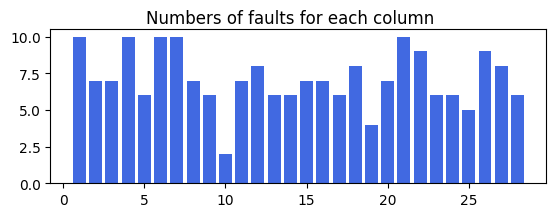

In [189]:
# vertial value faults barchart
mydb.execute("select p2 from faults")
row = mydb.fetchone()[0]
faultDepthsHorizontal = {}
while row is not None:
    if row in faultDepthsHorizontal:
        faultDepthsHorizontal[row] += 1
    else:
        faultDepthsHorizontal.update({row : 1})

    row = mydb.fetchone()
    if row is not None:
        row = row[0]
#pprint(faultDepths)
print(sum(faultDepthsHorizontal.values()))
f = plt.figure()
f.set_figheight(2)
plt.bar(faultDepthsHorizontal.keys(), faultDepthsHorizontal.values(), color="royalblue")
plt.suptitle("Numbers of faults for each column")
plt.savefig("figures/FaultsPerCol", bbox_inches="tight")
plt.show()

### Bit position injections

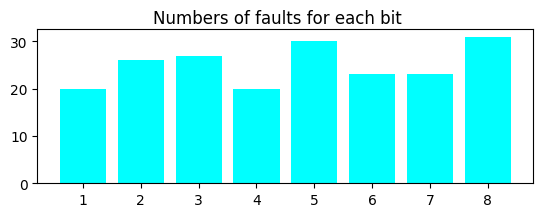

In [9]:
# vertial value faults barchart
mydb.execute("select bit from faults")
row = mydb.fetchone()[0]
faultBits = {}
while row is not None:
    if row in faultBits:
        faultBits[row] += 1
    else:
        faultBits.update({row : 1})

    row = mydb.fetchone()
    if row is not None:
        row = row[0]
#pprint(faultDepths)
f = plt.figure()
f.set_figheight(2)
plt.bar(faultBits.keys(), faultBits.values(), color="cyan")
plt.suptitle("Numbers of faults for each bit")
plt.show()

## Stimuli distribution

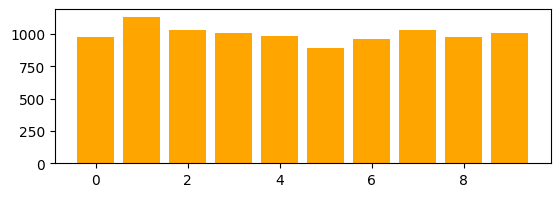

In [190]:
mydb.execute("select label, count(*) from stimuli group by label")
rows = mydb.fetchall()
rows = [tuple(r)[1] for r in rows]
f = plt.figure()
f.set_figheight(2)
plt.bar(range(10), rows, color="orange")
plt.savefig("figures/stimuliDistribution", bbox_inches="tight")
plt.show()

# Statistical analysis

In [228]:
faultTypes = ["masked", "good", "accept", "warning", "critical"]

### Statistics variables
# masked, good, accept, warning, critical
safety = [0, 0, 0, 0, 0]
# safety per channel. It is a dictionary devided by 
safetyPerChannel = [{},{},{},{},{}]
channelsTot = [0 for i in range(6)]
# vertical depth safety (only accept, warning and critical)
vertSafety = {0: {}, 1: {}, 2: {}, 3: {}, 4: {}}
# horizontal depth safety (only accept, warning and critical)
horSafety = {0: {}, 1: {}, 2: {}, 3: {}, 4: {}}
# bit position safety
bitPosSafety = {i:{} for i in range(5)}
# safety based on stimulus
stimuliSafety = {i:{} for i in range(5)}
# fault value
faultValueSafety = { i:[0, 0] for i in range(5) }
# fault value at 1 w.r.t. injected bit
bitPosStuckAt1 = {i: {} for i in range(5)}

# Total injection-stimulus pairs
total = 0

mydb.execute("""select * from faults as f, injections as i, stimuli as s
                    where i.stimulus_id = s.id 
                        and stimulus_id <= 1000 
                        and i.fault_id=f.id 
                    order by stimulus_id""")
# Order is id, channel, type, p1, p2, bit, value, stimulus_id, fault_id, probs...
row = mydb.fetchone()

#Indeces
rowKeys = row.keys()
probs_start_index = rowKeys.index("prob0")
channel_index = rowKeys.index("channel")
fault_index = rowKeys.index("fault_id")
stimulus_index = rowKeys.index("stimulus_id")
rowP_index = rowKeys.index("p1")
colP_index = rowKeys.index("p2")
bit_index = rowKeys.index("bit")
label_index = rowKeys.index("label")
fault_value_index = rowKeys.index("value")

row = tuple(row)
gold_stim = -1
while row is not None:
    stimulus = row[stimulus_index]
    fault  = row[fault_index]
    probs = row[probs_start_index:probs_start_index+10]
    channel = row[channel_index]
    rowP = row[rowP_index]
    colP = row[colP_index]
    bit = row[bit_index]
    label = row[label_index]
    fault_value = row[fault_value_index]
    
    total = total + 1
    if stimulus != gold_stim:
        gold.execute("select * from gold where stimulus = {}".format(stimulus))
        grow = gold.fetchone()
        [gold_stim, gold_probs] = [grow[0], grow[1:]]
        gold_pred = max(gold_probs)
        gold_label =  gold_probs.index(gold_pred)

    pred = max(probs)
    pred_label = probs.index(pred)

    # Masked
    if arrayEquals(probs, gold_probs):
        ftype = 0
    elif pred >= gold_pred and gold_label == pred_label: # good
        ftype = 1
    elif gold_label == pred_label and abs(pred-gold_pred)/gold_pred >= .05: # accept
        ftype = 2
    elif gold_label == pred_label: # warning
        ftype = 3
    else: # critical
        ftype = 4

    # General safety
    safety[ftype] += 1
    # Channel related
    if channel in safetyPerChannel[ftype]:
        safetyPerChannel[ftype][channel] += 1
    else:
        safetyPerChannel[ftype].update({channel: 1})
    channelsTot[channel-1] += 1
    
    # Vertical depth safety
    if rowP in vertSafety[ftype]:
        vertSafety[ftype][rowP] += 1
    else:
        vertSafety[ftype].update({rowP : 1})
    
    # horizontal safety
    if colP in horSafety[ftype]:
        horSafety[ftype][colP] += 1
    else:
        horSafety[ftype].update({colP: 1})
    
    #bit positions
    if bit in bitPosSafety[ftype]:
        bitPosSafety[ftype][bit] += 1
    else:
        bitPosSafety[ftype].update({bit : 1})   
    
    # fault value
    faultValueSafety[ftype][fault_value] += 1
    
    # bit pos w.r.t fault value
    if fault_value == 1:
        if bit in bitPosStuckAt0[ftype]:
            bitPosStuckAt1[ftype][bit] += 1
        else:
            bitPosStuckAt1[ftype].update({bit: 1})
    
    # stimului safety
    if label in stimuliSafety[ftype]:
        stimuliSafety[ftype][label] += 1
    else:
        stimuliSafety[ftype].update({label: 1})


    row = mydb.fetchone()
    if row is not None:
        row = tuple(row)

KeyError: 8

In [155]:
pprint(bitPosStuckAt1)

{0: {1: 5482, 2: 3308, 3: 2648, 4: 2528, 5: 3734, 6: 6441, 7: 5604, 8: 11776},
 1: {1: 703, 2: 7958, 3: 4491, 4: 4760, 5: 5429, 6: 4782, 7: 1890, 8: 2239},
 2: {1: 4, 2: 1872, 3: 1158, 4: 1499, 5: 553, 6: 176, 7: 12, 8: 2},
 3: {1: 810, 2: 2826, 3: 2649, 4: 3174, 5: 4274, 6: 2596, 7: 1492, 8: 982},
 4: {1: 1, 2: 36, 3: 54, 4: 39, 5: 11, 6: 5, 7: 2, 8: 2}}


# Stats visualization

## General safety

Masked: 64.89%
good: 20.14
accept: 3.09%
critical: 0.09%



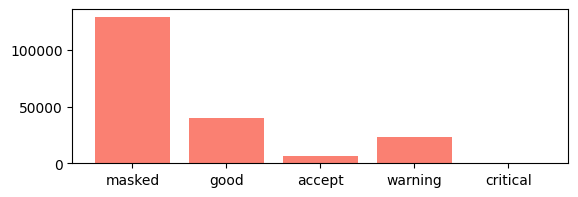

In [115]:
# General statistics
perc = [s / total * 100 for s in safety]
print("Masked: {:.2f}%\ngood: {:.2f}\naccept: {:.2f}%\nwarning: {:.2f}%\ncritical: {:.2f}%\n".format(perc[0], perc[1], perc[2], perc[3], perc[4]))

f = plt.figure()
f.set_figheight(2)

plt.bar(faultTypes, safety, color="salmon")
plt.show()

## Per-channel safety

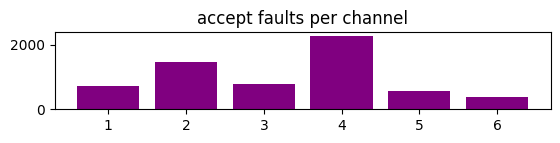

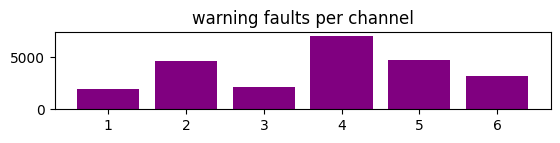

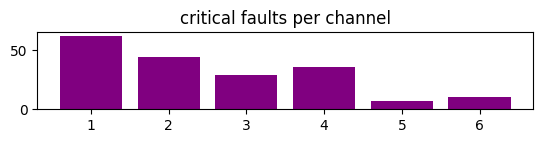

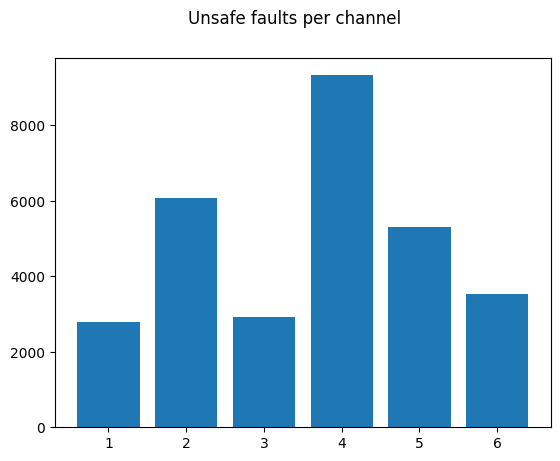

In [223]:
# Per Channel 
Total = [0 for i in range(0,7)]
for i, el in enumerate(safetyPerChannel[2:]):
    f = plt.figure()
    plt.bar(el.keys(), el.values(), color="purple")
    plt.title("%s faults per channel" % faultTypes[i+2])
    for i,e in el.items():
        Total[i] += e
    
    f.set_figheight(1)
    plt.show()


plt.bar(range(1,7), Total[1:])
plt.suptitle("Unsafe faults per channel")
plt.show()


## Safety based on vertical injections

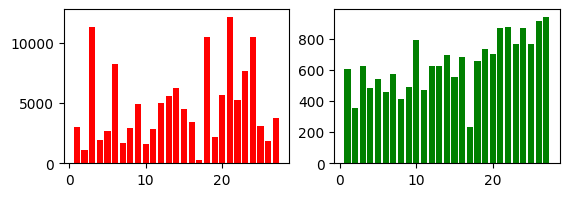

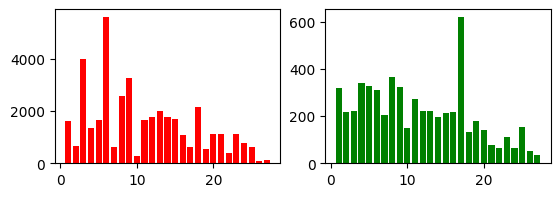

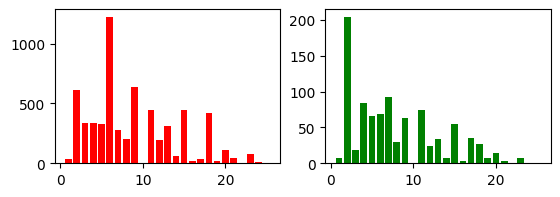

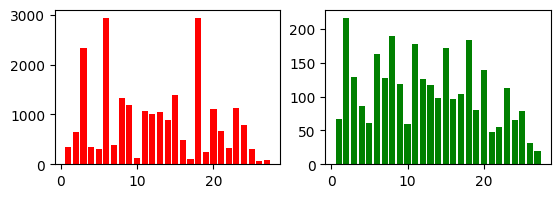

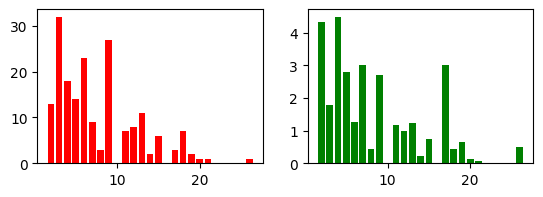

In [127]:
# Vertical
#pprint(vertSafety)
startIndex = 2
for el in vertSafety.values(): 
    # Since the distribution of vertical depth is not uniform, we normalize w.r.t. the number of injections
    values = [v/faultDepths[i] for i,v in el.items()]
    
    f = plt.figure()
    f.set_figheight(2)
    plt.subplot(1,2,1)
    plt.bar(el.keys(), el.values(), color="red")
    plt.subplot(1,2,2)
    plt.bar(el.keys(), values, color="green")
    plt.show() 

As expected, the smaller the depth, the more faults will be associated. Note also that most of the critical errors come from the first 9 rows.

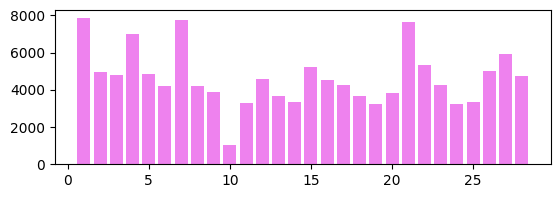

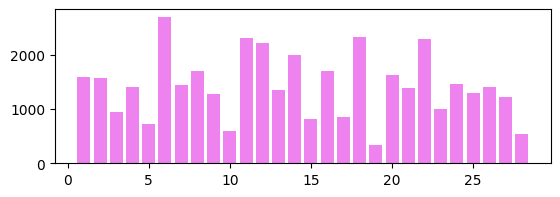

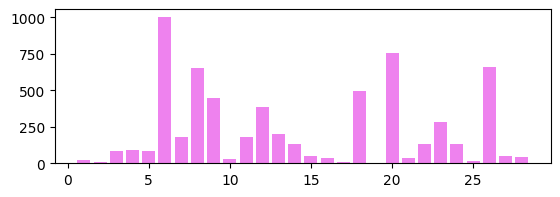

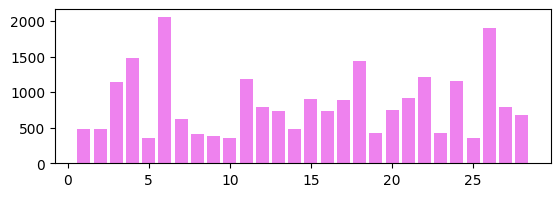

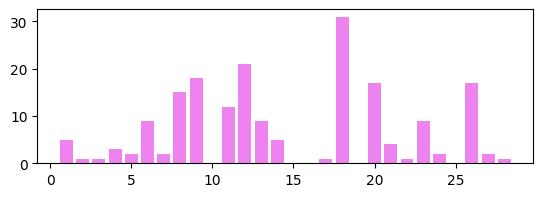

In [43]:
# Horizontal
for el in horSafety.values():
    f = plt.figure()
    f.set_figheight(2)
    plt.bar(el.keys(), el.values(), color="violet")
    plt.show() 

## Bit position

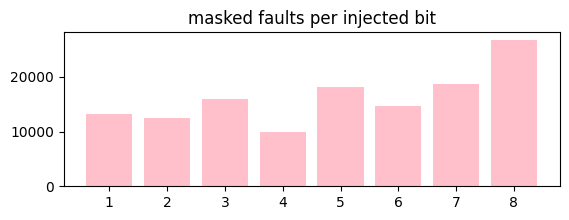

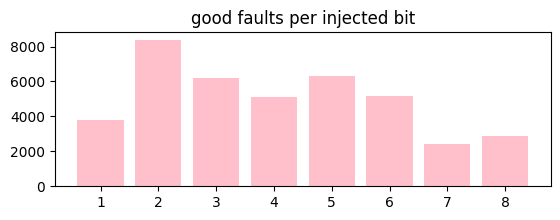

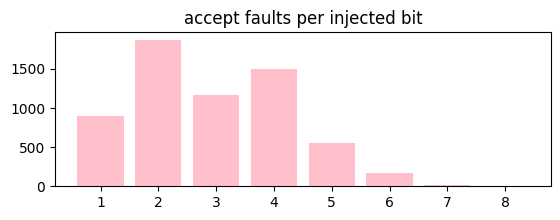

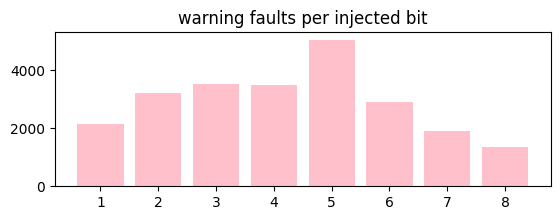

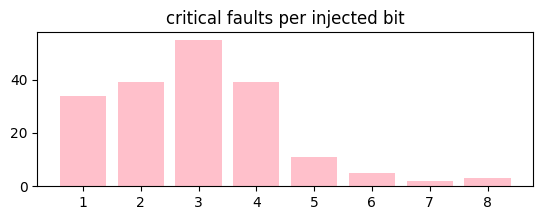

In [139]:
# Bit Position
Total = [0 for i in range(0,9)]
for i, el in enumerate(bitPosSafety.values()):
    f = plt.figure()
    f.set_figheight(2)
    plt.bar(el.keys(), el.values(), color="pink")
    plt.title(f"{faultTypes[i]} faults per injected bit")
    plt.show()

### Aggregate bit positions (unsafe - 2,3,4)

{5: 555, 2: 1874, 3: 1168, 1: 898, 4: 1500, 6: 176, 7: 13, 8: 4}
{5: 6174, 2: 7001, 3: 5920, 1: 3984, 4: 6528, 6: 3247, 7: 1920, 8: 1359}


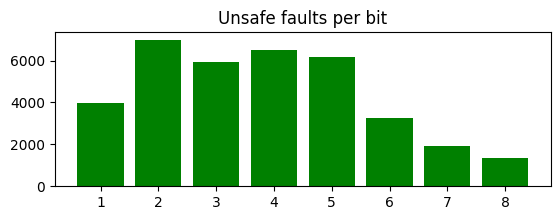

In [143]:
start = 2
bitPosTot = copy(bitPosSafety[start])
print( bitPosSafety[start])
for i in range(start,5):
    for el in bitPosSafety[i].keys():
        bitPosTot[el] += bitPosSafety[i][el]
print(bitPosTot)
f = plt.figure()
f.set_figheight(2)
plt.bar(bitPosTot.keys(), bitPosTot.values(), color="green")
plt.title("Unsafe faults per bit")
plt.show()

### Aggregate bit positions (2,3,4) normalized w.r.t. the number of injections per that bit

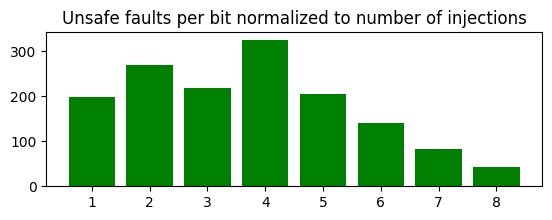

In [146]:
bitPosNormalized = { i:0 for i in faultBits.keys() }
for key in faultBits.keys():
    bitPosNormalized[key] = bitPosTot[key]/faultBits[key]
#pprint(bitPosNormalized)
f = plt.figure()
f.set_figheight(2)
plt.bar(bitPosNormalized.keys(), bitPosNormalized.values(), color="green")
plt.title("Unsafe faults per bit normalized to number of injections")
plt.show()

#### Bit depth faults distribution
Note: in this context the higher the number of the bit, the higher its importance. In other words, the MSB is bit 7

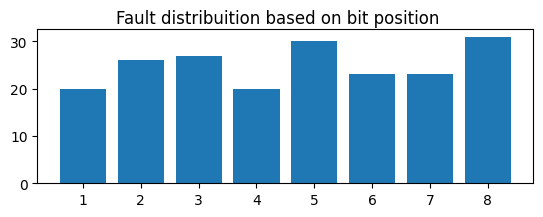

200


In [145]:
mydb.execute("select bit from faults")
row = mydb.fetchone()[0]
faultBits = {}
while row is not None:
    if row in faultBits:
        faultBits[row] += 1
    else:
        faultBits.update({row : 1})

    row = mydb.fetchone()
    if row is not None:
        row = row[0]
#pprint(faultDepths)
f = plt.figure()
f.set_figheight(2)
plt.bar(faultBits.keys(), faultBits.values())
plt.suptitle("Fault distribuition based on bit position")
plt.show()
print(sum(faultBits.values()))

Clearly, bits 6,7,8 are the least problematic, since they are the least important. On the other hand, bit 4 seems to be the most "weak" bit followd by bit 2 and 3. Looking at bits distribution in the weights, 

## Aggregate bit positions (all types)

{8: 57788, 7: 41660, 2: 38475, 4: 29875, 5: 48084, 3: 43030, 6: 37736, 1: 33136}


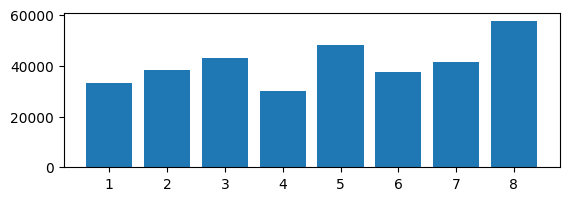

In [54]:
start = 0
bitPosTot = copy(bitPosSafety[start])
for i in range(start,5):
    for el in bitPosSafety[i].keys():
        bitPosTot[el] += bitPosSafety[i][el]
print(bitPosTot)
f = plt.figure()
f.set_figheight(2)
plt.bar(bitPosTot.keys(), bitPosTot.values())
plt.show()

In [ ]:
# NON STA FUNZIONANDO E NON SO IL PERCHÈ!
# Mi aspetto che la distribuzione 

totBits = sum(bitPosTot.values())
tot = sum(faultBits.values())
print([el / totBits for el in bitPosTot.values()])
print([el / tot for el in faultBits.values()])

## fault types w.r.t stimuli

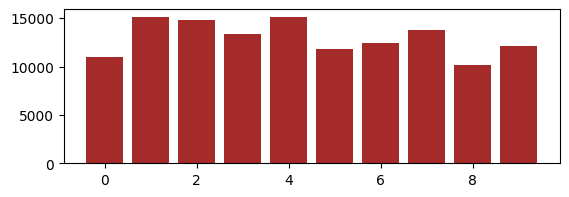

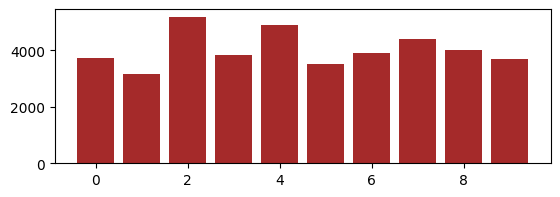

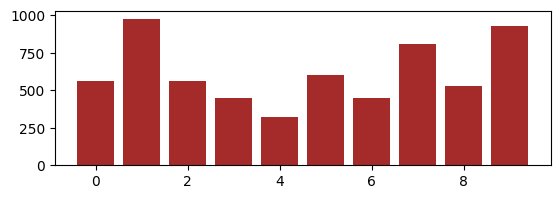

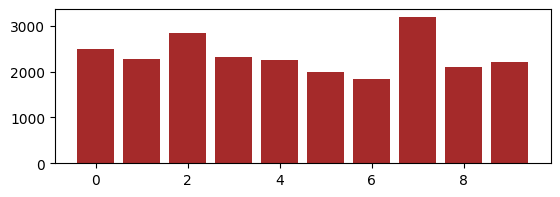

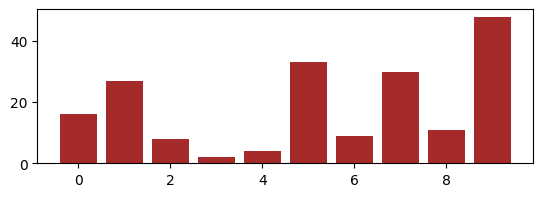

In [147]:
for el in stimuliSafety.values():
    f = plt.figure()
    f.set_figheight(2)
    plt.bar(el.keys(), el.values(), color="brown")
    plt.show()

## Fault w.r.t. fault value

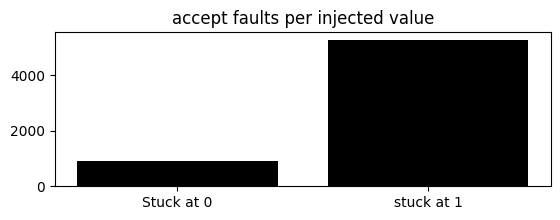

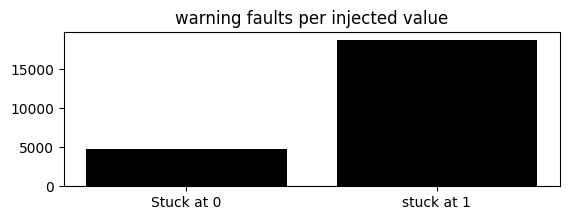

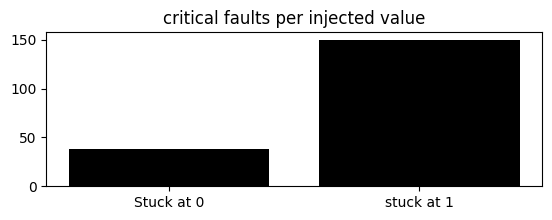

In [149]:
start = 2
for tipo, el in faultValueSafety.items():
    if tipo <=1:
        continue
    f = plt.figure()
    f.set_figheight(2)
    
    plt.bar(["Stuck at 0", "stuck at 1"], el, color="black")
    plt.title(f"{faultTypes[tipo]} faults per injected value")
    plt.show()

## 2d histogram of fault values and fault bits (normalized)

{1: 20, 2: 26, 3: 27, 4: 20, 5: 30, 6: 23, 7: 23, 8: 31}


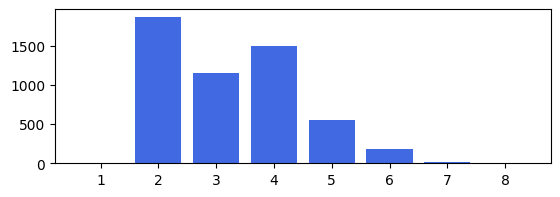

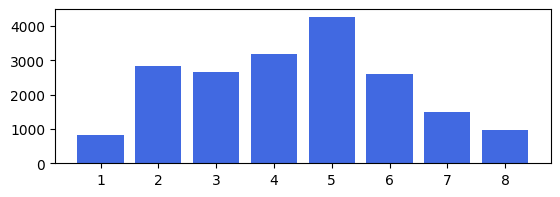

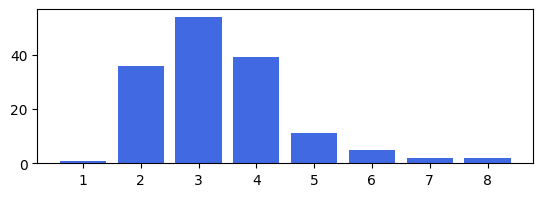

<BarContainer object of 8 artists>

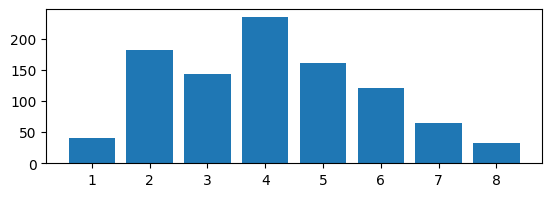

In [168]:
pprint(faultBits)
start = 2
Total = [0 for i in range(0, 9)]
for i,el in bitPosStuckAt0.items():
    if i < start:
        continue
        
    f = plt.figure()
    f.set_figheight(2)
    plt.bar(el.keys(), el.values(), color=COLORS[0])
    plt.show()
    
    for j, k in el.items():
        Total[j] += k
        
Total = [Total[j] / faultBits[j] for j in range(1,9)]
f = plt.figure()
f.set_figheight(2)
plt.bar([i for i in range(1,9)], Total)
        

<BarContainer object of 8 artists>

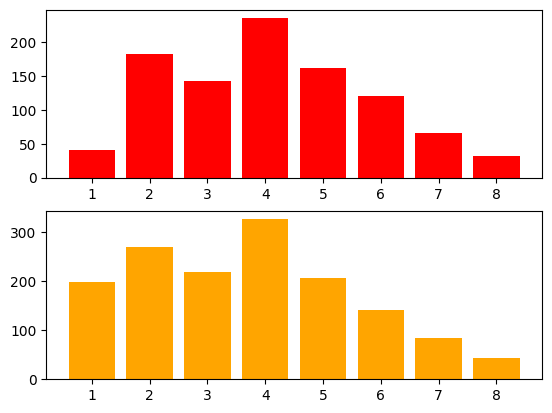

In [173]:
plt.subplot(2,1,1)
plt.bar([i for i in range(1,9)], Total, color="red")
plt.subplot(2,1,2)
plt.bar(bitPosNormalized.keys(), bitPosNormalized.values(), color="orange")